In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

#BenchmarkLQ_Mathematica
#MUST AGREE WITH MATHEMATICA PARAMETERS#

#MODEL PARAMETERS
#Model parameters: The parameter l is introduced in the space-variable. 
#m0 is supported \in (-l,l)#
T = 1.; Gamma = np.exp(1) ; Zeta = 5/6; Eta = 1.; Kappa = 1/6; bx0 = -1/4; l = 1.; c = 1.;
q0 = 1/2; bq = 1/4;

#DISCRETIZATION PARAMETERS
#N number of agents, M  number of time steps#
N = 3; M = 30; 
h = T/M; timesteps = np.linspace(0, T-h, M); timestepsT=np.append(timesteps,T)
tf.random.set_seed(10)

#MANUAL INSERTION OF THE EXACT PRICE...
PriceExact=0.015328310048810096*(100.16506721348814 - 10.87312731383618*timesteps + 8.154845485377136*timesteps**2)

#MANUAL INSERTION OF THE OPTIMAL TRAJECTORIES AND VELOCITIES...
OptimalXX=np.array([0.21912572159721186/2.718281828459045**(1.*timestepsT) - 0.029339477459567324*2.718281828459045**timestepsT + 0.25*timestepsT,
                    0.9238645303924419/2.718281828459045**(1.*timestepsT) - 0.07341437560229339*2.718281828459045**timestepsT + 0.24999999999999997*timestepsT,
                    -1.8929902519896533/2.718281828459045**(1.*timestepsT) + 0.1027538530618607*2.718281828459045**timestepsT + 0.25*timestepsT
                   ])
OptimalVV=np.array([0.25 - 0.21912572159721186/2.718281828459045**(1.*timesteps) - 0.029339477459567324*2.718281828459045**timesteps,
                    0.24999999999999997 - 0.9238645303924419/2.718281828459045**(1.*timesteps) -  0.07341437560229339*2.718281828459045**timesteps,
                    0.25 + 1.8929902519896533/2.718281828459045**(1.*timesteps) + 0.1027538530618607*2.718281828459045**timesteps  
                   ])

#READING PRICES FROM MATHEMATICA OUTPUT...
DiscreteTreeprice = np.loadtxt("DiscreteTreeprice.txt");
DiscreteHJprice = np.loadtxt("DiscreteHJprice.txt");
#READING INITIAL CONDITIONS FROM MATHEMATICA...
x0 = np.loadtxt("x0.txt");
x0=tf.convert_to_tensor(x0, dtype=tf.float32)


In [2]:
#Declare Terminal Cost uT#
def uT(x):
    return (Gamma/2)*(tf.math.square(x - Zeta))

#Declare initial m#
#Not implemented yet#

#SET SUPPLY explicit#
def Q(t):
    return (q0-bq)*np.exp(-t)+bq

#Declare running cost
def L(x,v):
    return tf.add((Eta/2)*(tf.math.square(x - Kappa)),
                  (c/2)*tf.math.square(v))

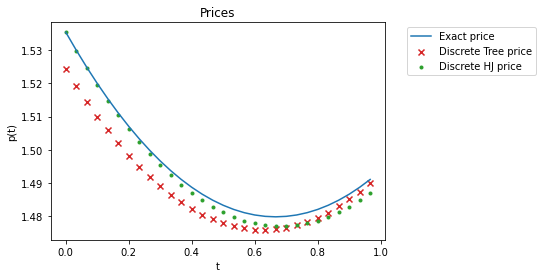

In [3]:
# Initiate plot object
plt.scatter(timesteps, DiscreteTreeprice, label = "Discrete Tree price",color ='tab:red', marker='x')
plt.scatter(timesteps, DiscreteHJprice, label = "Discrete HJ price",color ='tab:green', marker='.')
plt.plot(timesteps, PriceExact, label = "Exact price")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.xlabel('t');
plt.ylabel('p(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Prices')
plt.show()


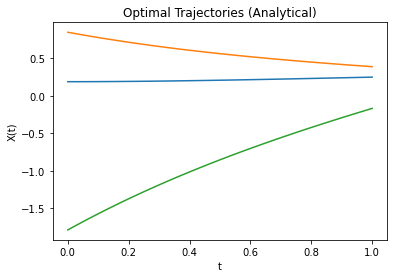

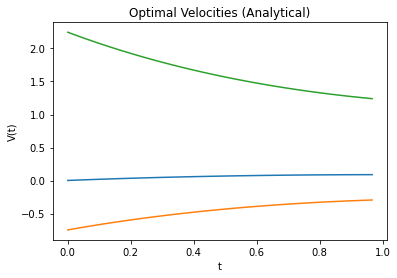

In [4]:
# Initiate plot object
plt.plot(timestepsT, OptimalXX.T)
plt.xlabel('t');
plt.ylabel('X(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Optimal Trajectories (Analytical)')
plt.show()


OptimalVV=np.array([0.25 - 0.21912572159721186/2.718281828459045**(1.*timesteps) - 0.029339477459567324*2.718281828459045**timesteps,
                    0.24999999999999997 - 0.9238645303924419/2.718281828459045**(1.*timesteps) -  0.07341437560229339*2.718281828459045**timesteps,
                    0.25 + 1.8929902519896533/2.718281828459045**(1.*timesteps) + 0.1027538530618607*2.718281828459045**timesteps  
                   ])
# Initiate plot object
plt.plot(timesteps, OptimalVV.T)
plt.xlabel('t');
plt.ylabel('V(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Optimal Velocities (Analytical)')
plt.show()


In [5]:
#NN parameters
learning_rate = 0.01
training_steps = 3001
display_step = 200


# Create model
multilayer_perceptron=tf.keras.Sequential()
multilayer_perceptron.add(tf.keras.Input(shape=(N+1,))) #N positions + time
multilayer_perceptron.add(Dense(256,activation='sigmoid')) #Layer 1
multilayer_perceptron.add(Dense(256,activation='sigmoid')) #Layer 2
multilayer_perceptron.add(Dense(256,activation='sigmoid')) #Layer 3
multilayer_perceptron.add(Dense(256,activation='sigmoid')) #Layer 4
multilayer_perceptron.add(Dense(N-1,activation=None)) #Layer Output N-1 velocities
multilayer_perceptron.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 199,170
Trainable params: 199,170
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Custom loss equals the variational cost for the N agents
#Impose balance by loss
def custom_loss(NN):
    positions=x0
    #summation is for the variational cost
    summation = []
    
    #initialize time 0
    velocities=NN(tf.concat([tf.constant([[0.]],dtype='float32'),tf.reshape(x0,[1,N])],axis=1))
    Nvelocity=tf.reshape(N*Q(0)-tf.math.reduce_sum(velocities),[1,1])
    velocities=tf.concat([velocities,Nvelocity],axis=1)
    runningcost0=[L(x0[i],velocities[0,i])*h for i in range(0,N)]
    summation.append(tf.reshape(tf.math.reduce_mean(runningcost0,keepdims=True),[1,1]))

    # The mean over players is computed per time step. Then we sum over timesteps
    
    #Compute runing cost per time t in (h,...,T-h)
    for t in timesteps[1:M]: 
        #Update positions using Forward dynamics. This position corresponds to the current time t
        positions=tf.add(positions,velocities*h)
        #Update velocities using current t,x and N
        velocities=NN(tf.concat([tf.constant([[t]],dtype='float32'),tf.reshape(positions,[1,N])],axis=1))
        Nvelocity=tf.reshape(N*Q(t)-tf.math.reduce_sum(velocities),[1,1])
        velocities=tf.concat([velocities,Nvelocity],axis=1)
        #Compute cost and append
        runningcost=[L(positions[0,i],velocities[0,i])*h for i in range(0,N)]
        summation.append(tf.reshape(tf.math.reduce_mean(runningcost,keepdims=True),[1,1]))
    
    #Compute the terminal cost
    #Update to get terminal position
    positions=tf.add(positions,velocities*h)
    terminalcost=tf.reshape(tf.reduce_mean([uT(positions[0,i]) for i in range(0,N)]),[1,1])
    summation.append(terminalcost)
    
    return tf.math.reduce_sum(summation)
#_sum vs _mean

In [7]:
def train_step(NN,optimizer):
    with tf.GradientTape(persistent=True) as tape:
        loss=custom_loss(NN)
    grad_NN=tape.gradient(loss,NN.trainable_variables)
    del tape
    optimizer.apply_gradients(zip(grad_NN, NN.trainable_variables))
    return loss

def train(NN,optimizer,training_steps):
    for i in range(training_steps):
        train_step(NN,optimizer)
        if i % display_step == 0:
            loss=custom_loss(NN)
            print("loss after iteration %i: %f " % (i,  loss))
            

tf.random.set_seed(0)
adam_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
train(multilayer_perceptron,adam_optimizer,training_steps)    
    

loss after iteration 0: 73.548828 
loss after iteration 200: 1.459727 
loss after iteration 400: 1.459727 
loss after iteration 600: 1.459727 
loss after iteration 800: 1.459726 
loss after iteration 1000: 1.459725 
loss after iteration 1200: 1.459725 
loss after iteration 1400: 1.459723 
loss after iteration 1600: 1.459714 
loss after iteration 1800: 1.459500 
loss after iteration 2000: 1.452012 
loss after iteration 2200: 1.452437 
loss after iteration 2400: 1.451968 
loss after iteration 2600: 1.451971 
loss after iteration 2800: 1.451987 
loss after iteration 3000: 1.452185 


Compute the price using the Karush-Kuhn_Tucker condition 
$$ D_{\bf v}\left( \frac{1}{N} \sum_{i=1}^N \sum_{k=0}^{M-1} h*L(X^i_k,v^i_k) + \Psi(X^i_M)\right) + \sum_{k=0}^{M-1} \varpi_k D_{\bf v} g_k({\bf v}) = {\bf 0}, $$
where 
$${\bf v}=(v^1_0,\ldots,v^1_{M-1},\ldots,v^N_0,\ldots,v^N_{M-1}),$$
$$ X^i_k=X^i_k(v^i_0,\ldots,v^i_{k-1}),$$
$$g_k({\bf v})=\frac{1}{N} \sum_{i=1}^N v^i_k - Q_k,\quad k=0,\ldots,M-1$$

For the LQ model, we have
$$ \varpi=-\frac{1}{h} D_{\bf v^i} \left( \sum_{k=0}^{M-1} h*L(X^i_k,v^i_k) + \Psi(X^i_M)\right):=-\frac{1}{h}D_{\bf v^i} L(i)$$
for $1\leq i \leq N$.

In [8]:
#Compute (X,V) for all agents

#initialize time 0
ptemp=tf.reshape(x0,[1,N])
Xvector=ptemp
NNV0=multilayer_perceptron(tf.concat([tf.constant([[0.]],dtype='float32'),tf.reshape(x0,[1,N])],axis=1))
Nvelocity=tf.reshape(N*Q(0)-tf.math.reduce_sum(NNV0),[1,1])
Vvector=tf.concat([NNV0,Nvelocity],axis=1)


#Compute velocities per time t in (h,...,T-h)
for cc in range(1,M):
    #Update positions using Forward dynamics. This position corresponds to the current time t
    ptemp=tf.add(ptemp,Vvector[cc-1,:]*h)
    Xvector=tf.concat([Xvector,ptemp],axis=0)
    #Update velocities using current t,x and N
    NNV0=multilayer_perceptron(tf.concat([tf.constant([[cc*h]],dtype='float32'),tf.reshape(ptemp,[1,N])],axis=1))
    Nvelocity=tf.reshape(N*Q(cc*h)-tf.math.reduce_sum(NNV0),[1,1])
    Vvector=tf.concat([Vvector,tf.concat([NNV0,Nvelocity],axis=1)],axis=0)
    
    
#Update last position
ptemp=tf.add(ptemp,Vvector[M-1,:]*h)
Xvector=tf.concat([Xvector,ptemp],axis=0)

Xvector=Xvector.numpy()
Vvector=Vvector.numpy()

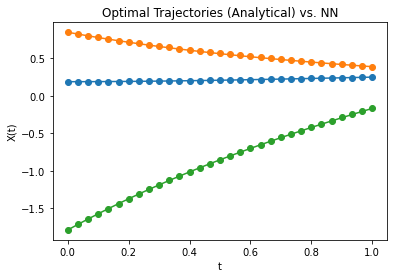

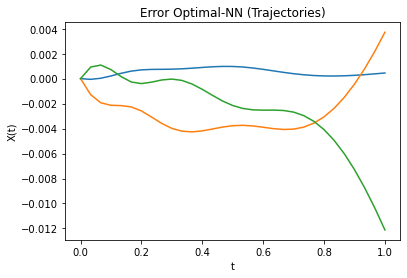

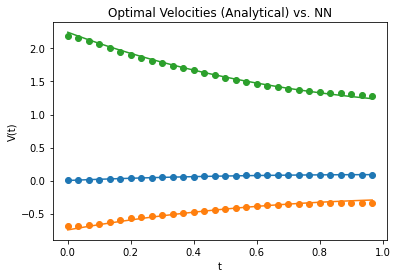

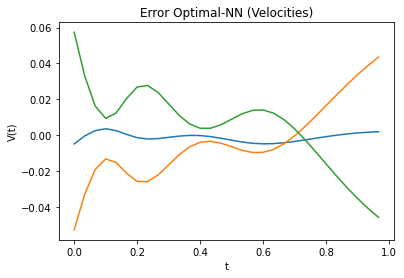

In [9]:
# Initiate plot object
plt.plot(timestepsT, OptimalXX.T)
plt.scatter(timestepsT, Xvector[:,0])
plt.scatter(timestepsT, Xvector[:,1])
plt.scatter(timestepsT, Xvector[:,2])
plt.xlabel('t');
plt.ylabel('X(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Optimal Trajectories (Analytical) vs. NN')
plt.show()

XErr=OptimalXX-Xvector.T

# Initiate plot object
plt.plot(timestepsT, XErr.T)
plt.xlabel('t');
plt.ylabel('X(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Error Optimal-NN (Trajectories)')
plt.show()

# Initiate plot object
plt.plot(timesteps, OptimalVV.T)
plt.scatter(timesteps, Vvector[:,0])
plt.scatter(timesteps, Vvector[:,1])
plt.scatter(timesteps, Vvector[:,2])
plt.xlabel('t');
plt.ylabel('V(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Optimal Velocities (Analytical) vs. NN')
plt.show()

VErr=OptimalVV-Vvector.T
# Initiate plot object
plt.plot(timesteps, VErr.T)
plt.xlabel('t');
plt.ylabel('V(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Error Optimal-NN (Velocities)')
plt.show()


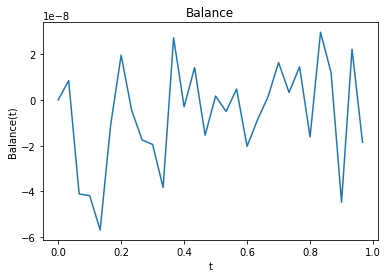

In [10]:
VBalance=np.mean(Vvector,axis=1)-Q(timesteps)
# Initiate plot object
plt.plot(timesteps, VBalance)
plt.xlabel('t');
plt.ylabel('Balance(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Balance')
plt.show()

In [17]:
#Select a player and initialize its v variable
Player=0;
VvectorPlayer=tf.Variable([1. for c in range(M)],dtype='float32')
with tf.GradientTape(persistent=True) as tape:
    tape.watch(VvectorPlayer)
    
    #initialize time 0
    ptemp=tf.reshape(x0[Player],[1])
    VvectorPlayer[0].assign(Vvector[0,Player])
    Li=h*L(ptemp,VvectorPlayer[0])

    #Compute velocities per time t in (h,...,T-h)
    for cc in range(1,M):
        #Update positions using Forward dynamics. This position corresponds to the current time t
        ptemp=tf.add(ptemp,VvectorPlayer[cc-1]*h)
        #Update velocities using current t,x and N
        VvectorPlayer[cc].assign(Vvector[cc,Player])
        #compute running cost
        Li=tf.add(Li,h*L(ptemp,VvectorPlayer[cc]))
    #Update last position
    ptemp=tf.add(ptemp,VvectorPlayer[M-1]*h)
    #compute terminal cost
    Li=tf.add(Li,uT(ptemp))    

dLi_dvi = tape.gradient(Li, VvectorPlayer)
dLi_dvi

priceNN=(-1/h)*dLi_dvi
priceNN=priceNN.numpy()[0:M]
priceNN

array([1.5341271, 1.5331533, 1.5310034, 1.5271667, 1.5215751, 1.5151422,
       1.5092932, 1.5048035, 1.5015554, 1.4990559, 1.4968364, 1.4945815,
       1.4921353, 1.489489 , 1.4867597, 1.484153 , 1.4819089, 1.480234 ,
       1.4792501, 1.4789747, 1.4793421, 1.4802428, 1.4815638, 1.4832083,
       1.4851048, 1.4872022, 1.4894667, 1.4918755, 1.4944134, 1.497071 ],
      dtype=float32)

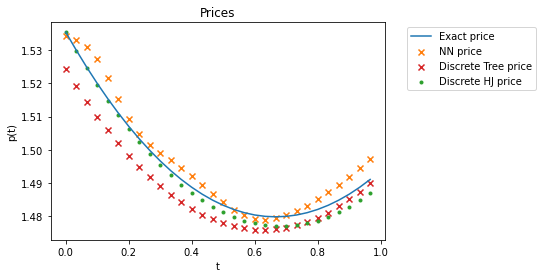

In [18]:
# Initiate plot object
plt.scatter(timesteps, priceNN, label = "NN price",color ='tab:orange', marker='x')
plt.scatter(timesteps, DiscreteTreeprice, label = "Discrete Tree price",color ='tab:red', marker='x')
plt.scatter(timesteps, DiscreteHJprice, label = "Discrete HJ price",color ='tab:green', marker='.')
plt.plot(timesteps, PriceExact, label = "Exact price")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.xlabel('t');
plt.ylabel('p(t)');
#ax = plt.axes()
#ax.set_facecolor("lightgrey")
plt.title('Prices')
plt.show()

